# nGram -- initial plots

This document contains a bunch of plots that will exlain why we use a certain baseline for the project.

## Preparation

load modules and data

In [1]:
include("../julia/lib.jl")
include("../julia/img.jl")
using Gadfly
using DataFrames

set_default_plot_size(25cm, 15cm)

map_i2s, map_s2i = loadmap("../cpp/build/k-stems.map")
n = length(map_i2s) - 1  # TODO: fix the map loader!
m = 256
data = loaddata("../cpp/build/d0.data", m, n)

year_first = 1753
t = collect(year_first:(year_first + m - 1))
print()

In [2]:
function get_from_data(data, i, fnorm=norm_id, ftransform=transform_id)
    x_transformed = ftransform(convert(Array{Float64}, data[:,i]))
    return x_transformed * fnorm(x_transformed)
end

function plot_all_that(data, map_s2i, t, ngrams, fnorm, ftransform, title)
    dfs = map(ng -> DataFrame(x=t, y=get_from_data(data, map_s2i[ng], fnorm, ftransform), label=ng), ngrams)
    df = reduce(vcat, DataFrame(), dfs)
    plot(
        df,
        x="x",
        y="y",
        color="label",
        Geom.line,
        Guide.xlabel("Year"),
        Guide.ylabel("n"),
        Guide.colorkey("ngram"),
        Guide.title(title),
        Guide.xticks(ticks=collect(minimum(t):16:maximum(t)))
    )
end
print()

## Why we cannot use percentages

First we pick some *tiny* and some *huge* time series:

In [3]:
sums = sort(map(i -> (i, sum(data[:,i])), 1:n), by=x -> x[2])
d_tiny = convert(Int, floor(n * 0.95))
d_huge = convert(Int, floor(n * 0.9998))
n_samples = 3
ngrams_tiny = map(x -> map_i2s[x[1]], sums[d_tiny:(d_tiny + n_samples - 1)])
ngrams_huge = map(x -> map_i2s[x[1]], sums[d_huge:(d_huge + n_samples - 1)])
totals = map(
    x -> max(x, 100.0),
    convert(
        Array{Float64},
        reduce(
            (a, b) -> a + b,
            0,
            map(
                s -> data[:,map_s2i[s]],
                vcat(ngrams_tiny, ngrams_huge)
            )
        )
    )
)
println("nGrams huge: ", ngrams_huge)
println("nGrams tiny: ", ngrams_tiny)

nGrams huge: SubString{UTF8String}

### Absolute values

Note that the *tiny* series are not even plotted compared to the *huge* ones:

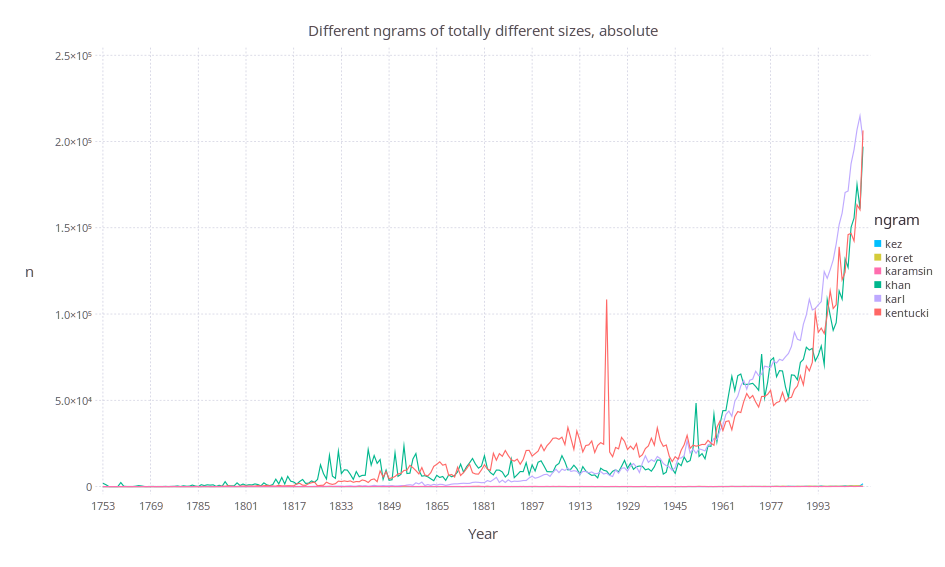

["khan","karl","kentucki"]
nGrams tiny: SubString{UTF8String}["kez","koret","karamsin"]


In [4]:
plot_all_that(data, map_s2i, t, vcat(ngrams_tiny, ngrams_huge) , norm_id, transform_id, "Different ngrams of totally different sizes, absolute")

### Relative values

Now we plot the values relative to the sum of all 6 time series. When doing so, the gradients of the *huge* series seem to be heavily correlated:

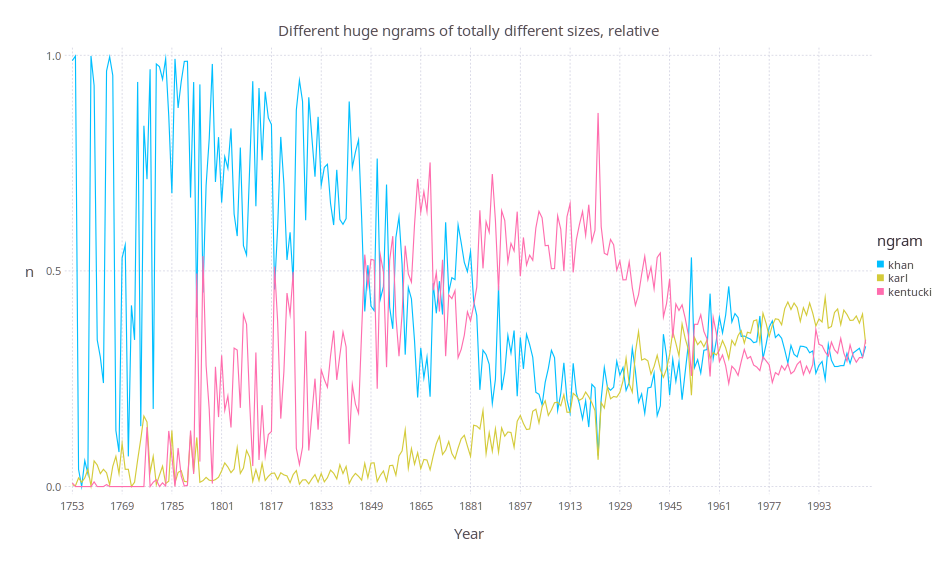

In [5]:
transform_percentages = x -> x ./ totals
plot_all_that(data, map_s2i, t, ngrams_huge, norm_id, transform_percentages, "Different huge ngrams of totally different sizes, relative")

Similar behaviour can be observed when plotting the *tiny* series. Here, the tend to move in a similar direction more often, esp. during the period around 1960:

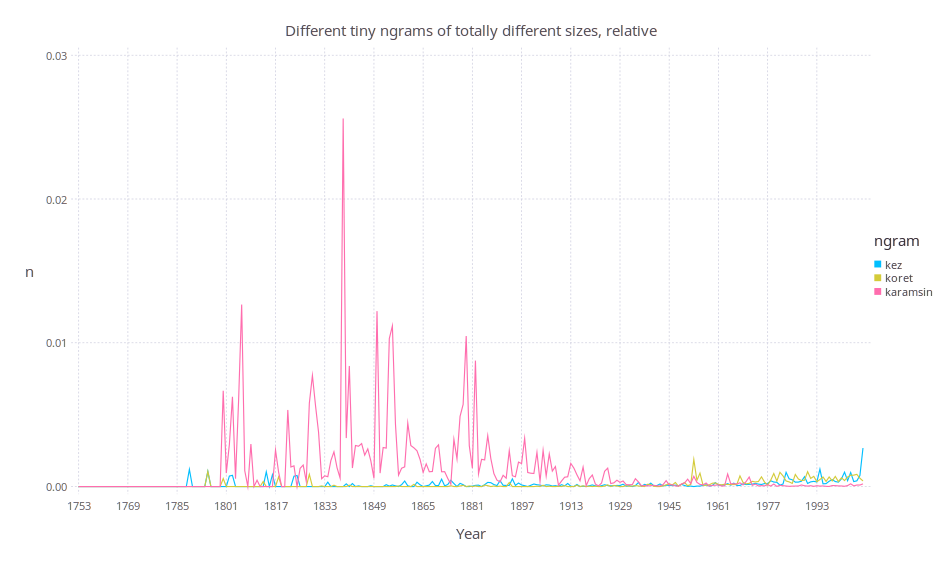

In [6]:
plot_all_that(data, map_s2i, t, ngrams_tiny, norm_id, transform_percentages, "Different tiny ngrams of totally different sizes, relative")

When plotting the total numbers, no such correlation can be observed:

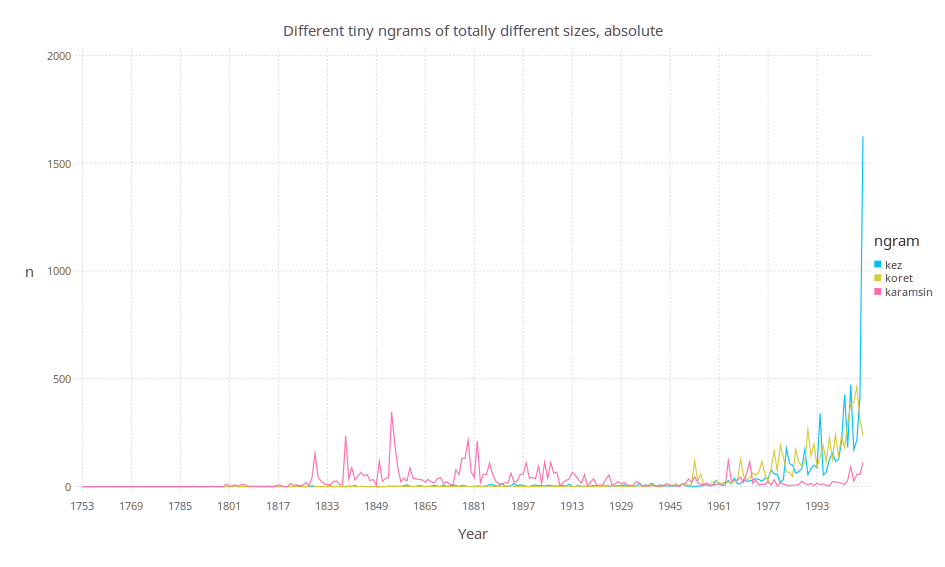

In [7]:
plot_all_that(data, map_s2i, t, ngrams_tiny, norm_id, transform_id, "Different tiny ngrams of totally different sizes, absolute")

Same holds for logarithmic scale:

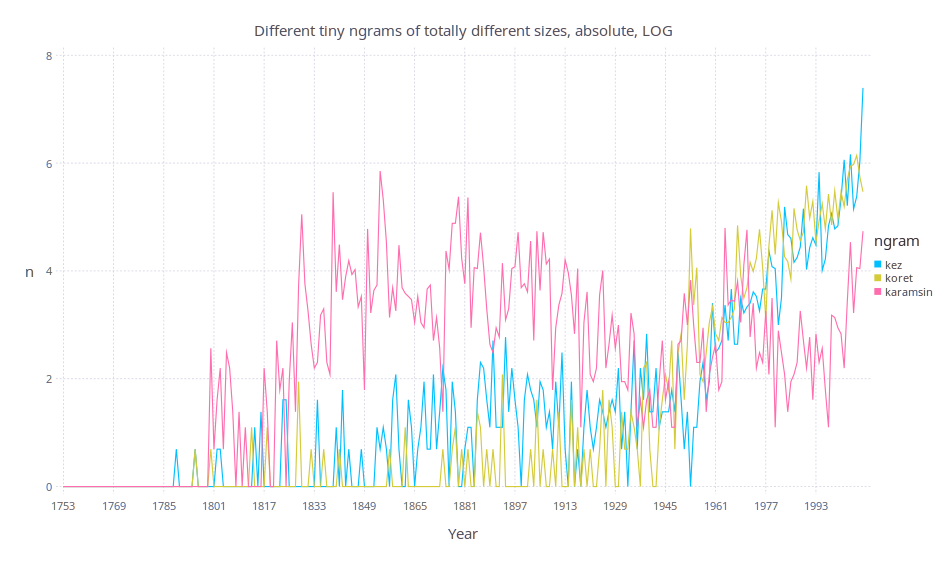

In [8]:
plot_all_that(data, map_s2i, t, ngrams_tiny, norm_id, transform_log, "Different tiny ngrams of totally different sizes, absolute, LOG")

So the similarity of the gradients must be introduced because of the relativization. Therefore, this procedure is unusable for us. We will continue by using total numbers instead.

## Why we need gradients

In [9]:
ngrams = ["know", "kiss", "kind", "keep"]

4-element Array{ASCIIString,1}:
 "know"
 "kiss"
 "kind"
 "keep"

### Linear fitting

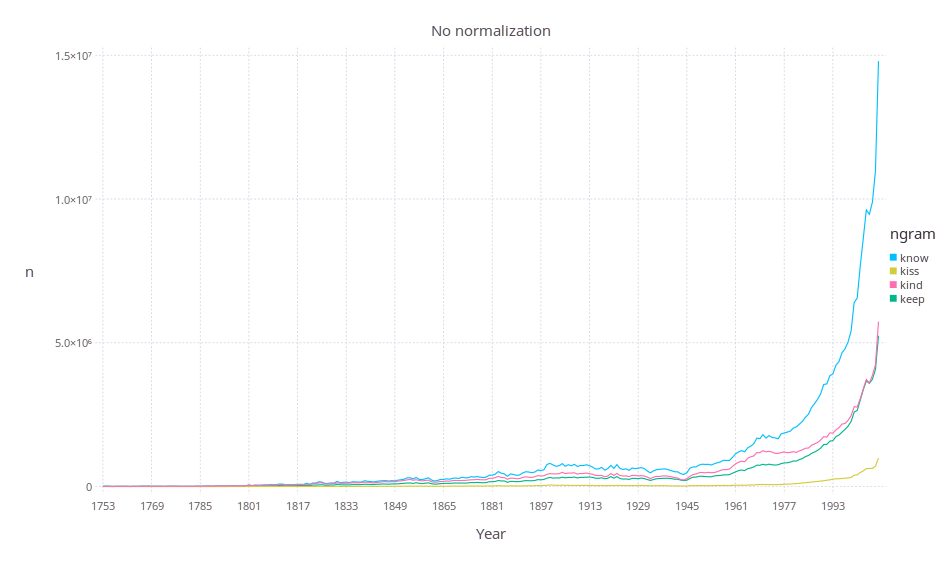

In [10]:
plot_all_that(data, map_s2i, t, ngrams , norm_id, transform_id, "No normalization")

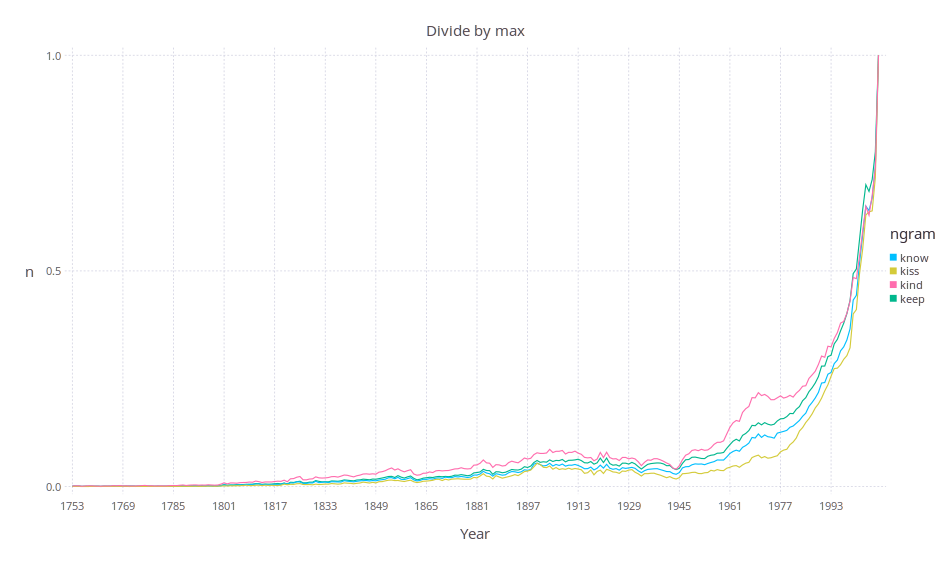

In [11]:
plot_all_that(data, map_s2i, t, ngrams , norm_max, transform_id, "Divide by max")

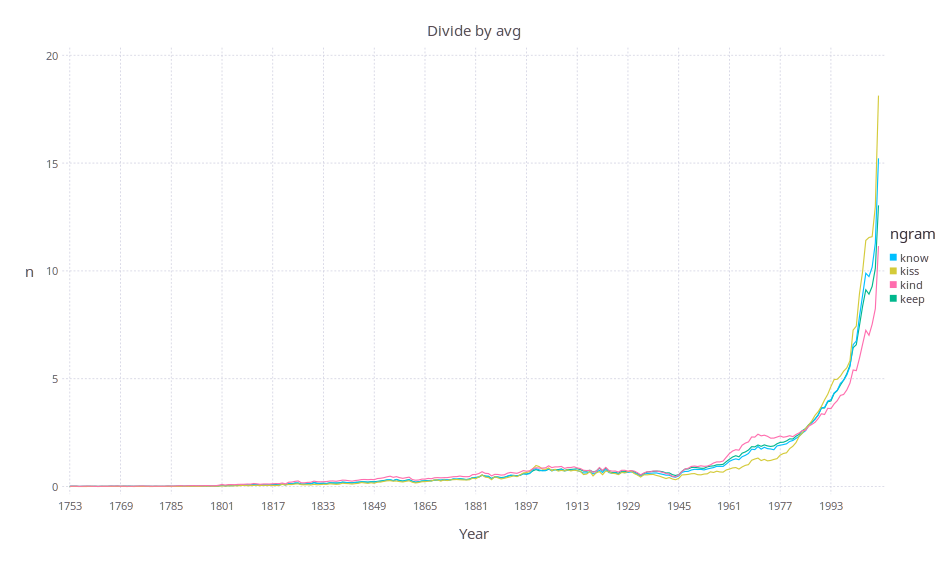

In [12]:
plot_all_that(data, map_s2i, t, ngrams , norm_avg, transform_id, "Divide by avg")

### Logarithmic fitting

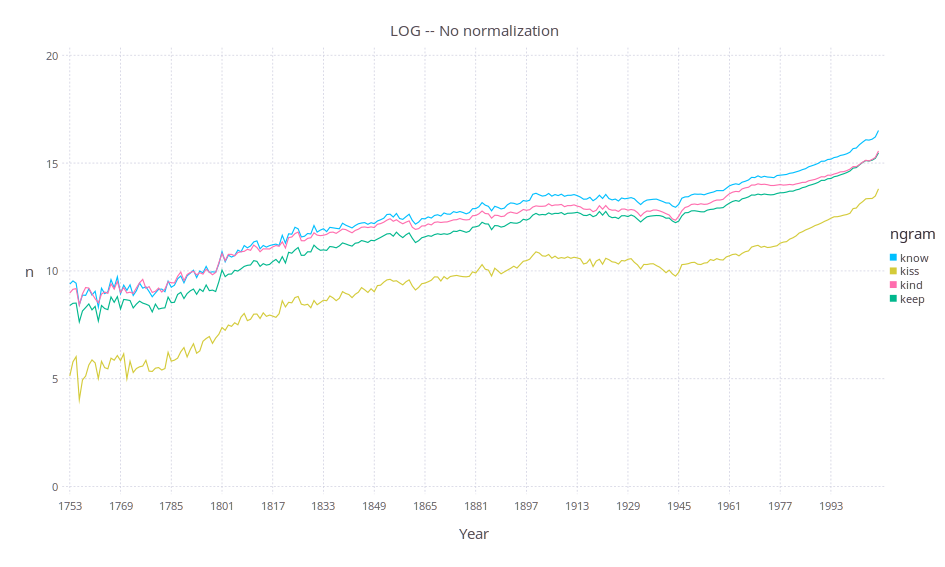

In [13]:
plot_all_that(data, map_s2i, t, ngrams , norm_id, transform_log, "LOG -- No normalization")

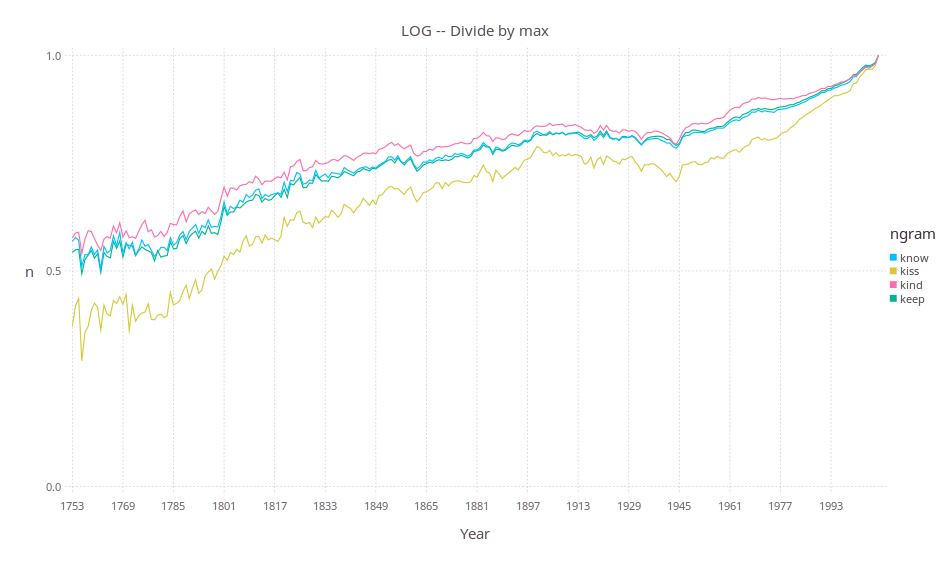

In [14]:
plot_all_that(data, map_s2i, t, ngrams , norm_max, transform_log, "LOG -- Divide by max")

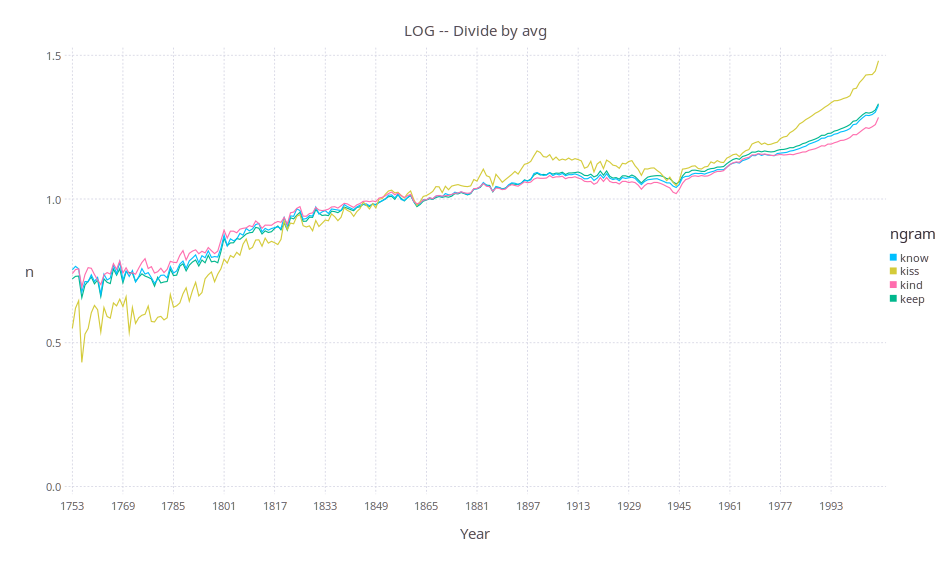

In [15]:
plot_all_that(data, map_s2i, t, ngrams , norm_avg, transform_log, "LOG -- Divide by avg")

### Fitting of gradients

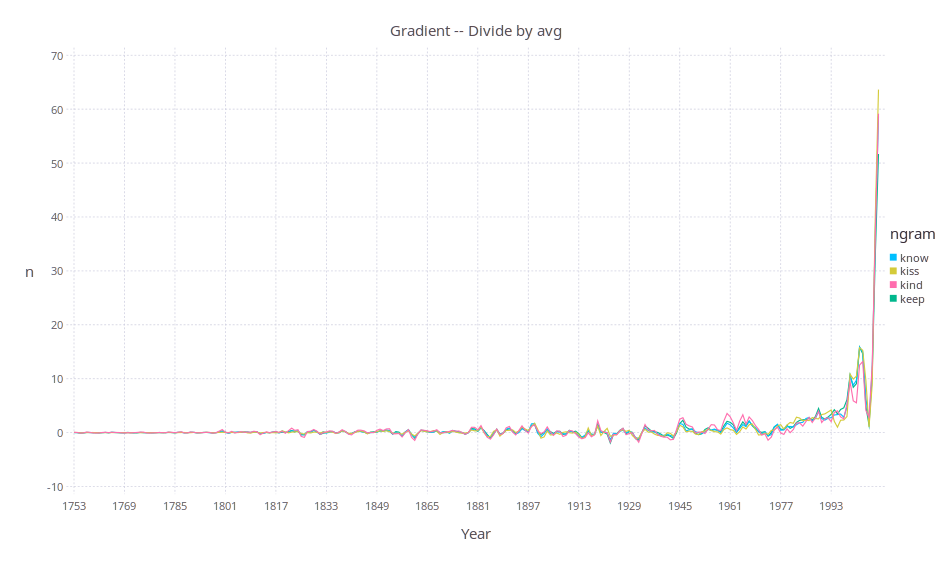

In [16]:
transform_gradient = x -> gradient(x)
plot_all_that(data, map_s2i, t, ngrams , norm_avg, transform_gradient, "Gradient -- Divide by avg")

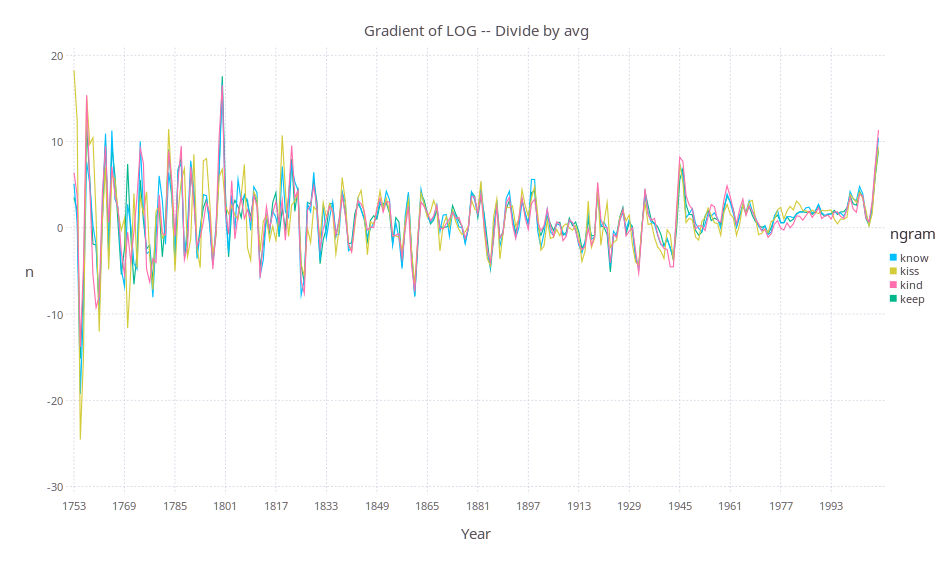

In [17]:
transform_loggradient = x -> gradient(log(1.0 + x))
plot_all_that(data, map_s2i, t, ngrams , norm_avg, transform_loggradient, "Gradient of LOG -- Divide by avg")

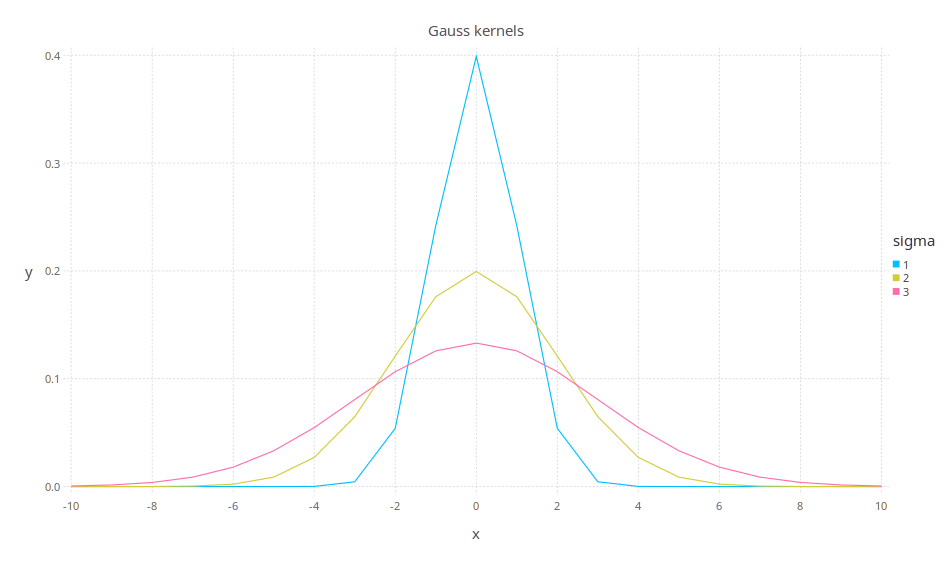

In [18]:
kernel_gauss_sigma1 = gengausskernel(10, 1)
kernel_gauss_sigma2 = gengausskernel(10, 2)
kernel_gauss_sigma3 = gengausskernel(10, 3)
plot(
    vcat(
        DataFrame(x=collect(-10:10), y=kernel_gauss_sigma1, label="1"),
        DataFrame(x=collect(-10:10), y=kernel_gauss_sigma2, label="2"),
        DataFrame(x=collect(-10:10), y=kernel_gauss_sigma3, label="3")
    ),
    x="x",
    y="y",
    color="label",
    Geom.line,
    Guide.colorkey("sigma"),
    Guide.title("Gauss kernels"),
    Guide.xticks(ticks=collect(-10:2:10))
)

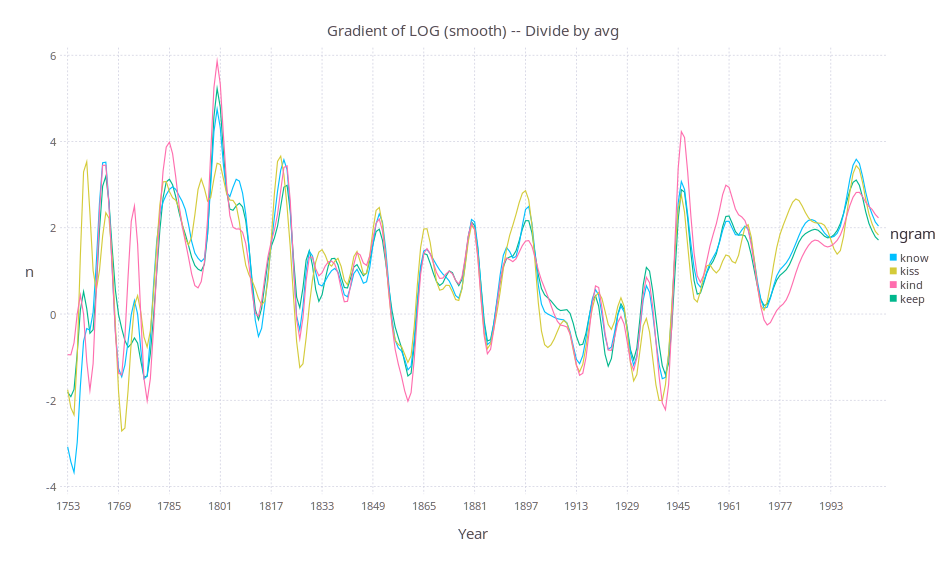

In [19]:
transform_loggradient_smooth = x -> gradient(applykernel(log(1.0 + x), kernel_gauss_sigma2))
plot_all_that(data, map_s2i, t, ngrams , norm_avg, transform_loggradient_smooth, "Gradient of LOG (smooth) -- Divide by avg")

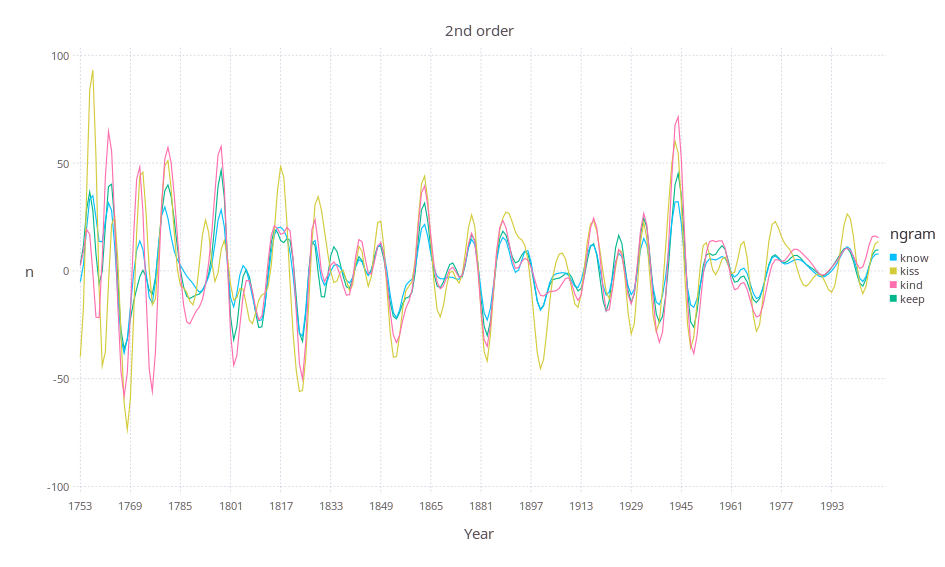

In [20]:
transform_foo_second = x -> gradient(applykernel(gradient(applykernel(log(1.0 + x), kernel_gauss_sigma1)), kernel_gauss_sigma2))
plot_all_that(data, map_s2i, t, ngrams , norm_avg, transform_foo_second, "2nd order")

## FFT experiments

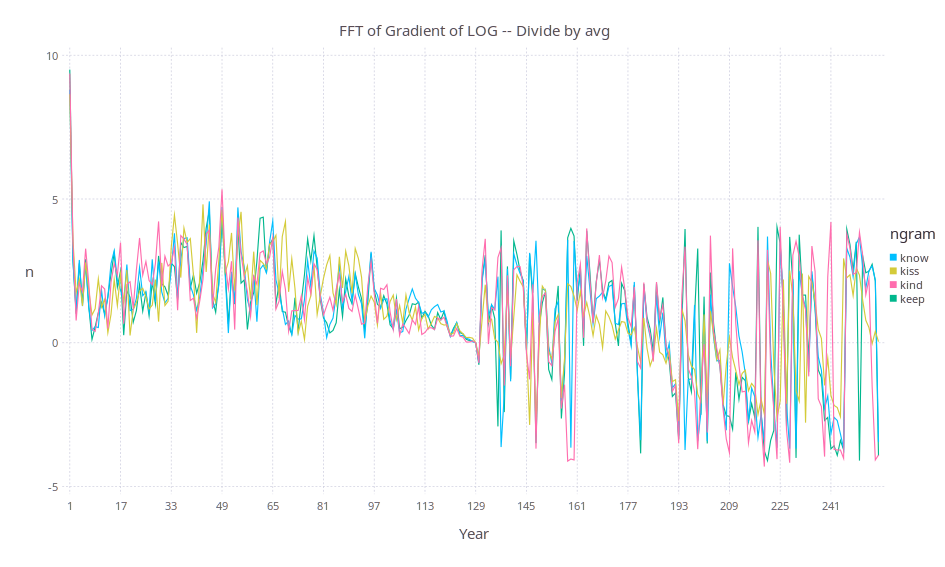

In [21]:
function transform_loggradient_fft(x)
    gradient = transform_loggradient(x)
    transformed = fft(gradient)
    v_abs = abs(transformed)
    v_angle = angle(transformed)
    l = convert(Int, length(transformed) / 2)
    return vcat(v_abs[1:l], v_angle[1:l])
end
plot_all_that(data, map_s2i, collect(1:m), ngrams , norm_avg, transform_loggradient_fft, "FFT of Gradient of LOG -- Divide by avg")

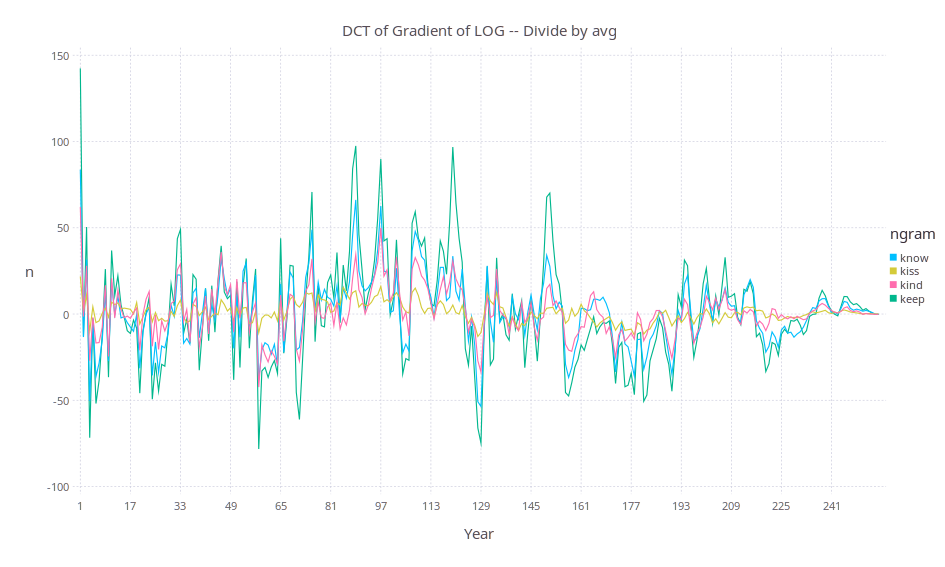

In [22]:
function transform_loggradient_dct(x)
    gradient = transform_loggradient(x)
    transformed = dct(gradient)
    return transformed
end
plot_all_that(data, map_s2i, collect(1:m), ngrams , norm_avg, transform_loggradient_dct, "DCT of Gradient of LOG -- Divide by avg")